# Multimodal EMG-EEG Gesture Classification using Deep Learning
implements a multimodal deep learning approach combining EMG and EEG data for gesture classification.


In [1]:
import os
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc


In [2]:

# Set memory optimization flags and reproducibility
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


Configuration and Hyperparameters

In [3]:
# Data paths
EMG_DATA_PATH = 'data/processed/EMG-data.csv'
EEG_DATA_PATH = 'data/processed/EEG-data.csv'

# Data processing parameters
DELTA_T = 35  # Time difference between EEG and EMG in ms
WINDOW_SIZE = 200  # Window size for data processing

# Model hyperparameters
BATCH_SIZE = 32
INITIAL_LR = 0.001  # Initial learning rate
MIN_LR = 1e-6      # Minimum learning rate
WEIGHT_DECAY = 1e-5
HIDDEN_DIM = 64

# Training settings
TRAIN_TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2
RANDOM_SEED = 42

# Learning rate scheduler settings
NUM_EPOCHS = 50  # Will run for full 100 epochs
WARMUP_EPOCHS = 5
CYCLES = 3  # Number of cosine annealing cycles
CYCLE_LEN = NUM_EPOCHS // CYCLES  # Length of each cycle
T_MULT = 2  # Factor to increase cycle length after each cycle
ETA_MIN = MIN_LR  # Minimum learning rate for cosine annealing

# Training improvements
GRAD_CLIP_VAL = 1.0  # Gradient clipping value
LABEL_SMOOTHING = 0.1  # Label smoothing factor


Helper Functions

In [4]:
def load_and_preprocess_data(emg_path, eeg_path, window_size=WINDOW_SIZE):
    print("Loading data...")
    
    # Load data
    emg_data = pd.read_csv(emg_path)
    eeg_data = pd.read_csv(eeg_path)
    
    # Extract features and labels
    emg_features = emg_data.iloc[:, :8].values  # 8 EMG channels
    eeg_features = eeg_data.iloc[:, :8].values  # 8 EEG channels
    
    # Standardize features
    print("Normalizing data...")
    emg_scaler = StandardScaler()
    eeg_scaler = StandardScaler()
    
    emg_features = emg_scaler.fit_transform(emg_features)
    eeg_features = eeg_scaler.fit_transform(eeg_features)
    
    # Create windowed data
    emg_windows = []
    eeg_windows = []
    window_labels = []
    sample_ids = []  # Track sample IDs for stratified splits
    
    # Find common samples between EMG and EEG data
    emg_samples = set(tuple(x) for x in emg_data[['subject', 'repetition', 'gesture']].drop_duplicates().values)
    eeg_samples = set(tuple(x) for x in eeg_data[['subject', 'repetition', 'gesture']].drop_duplicates().values)
    common_samples = emg_samples.intersection(eeg_samples)
    
    print(f"Found {len(common_samples)} common samples between EMG and EEG data.")
    
    for sample in common_samples:
        subject, repetition, gesture = sample
        
        # Get data for this sample
        emg_sample = emg_data[(emg_data['subject'] == subject) & 
                             (emg_data['repetition'] == repetition) & 
                             (emg_data['gesture'] == gesture)]
        
        eeg_sample = eeg_data[(eeg_data['subject'] == subject) & 
                             (eeg_data['repetition'] == repetition) & 
                             (eeg_data['gesture'] == gesture)]
        
        # Make sure both samples have data
        if len(emg_sample) == 0 or len(eeg_sample) == 0:
            continue
            
        # Extract features
        emg_sample_features = emg_sample.iloc[:, :8].values
        eeg_sample_features = eeg_sample.iloc[:, :8].values
        
        # Standardize using pre-fitted scalers
        emg_sample_features = emg_scaler.transform(emg_sample_features)
        eeg_sample_features = eeg_scaler.transform(eeg_sample_features)
        
        # Handle different lengths by using the shorter one
        min_length = min(len(emg_sample_features), len(eeg_sample_features))
        if min_length <= window_size:
            continue  # Skip if sample is too short
            
        emg_sample_features = emg_sample_features[:min_length]
        eeg_sample_features = eeg_sample_features[:min_length]
        
        # Create windows with fixed size
        for i in range(0, min_length - window_size, window_size // 2):
            emg_window = emg_sample_features[i:i + window_size]
            eeg_window = eeg_sample_features[i:i + window_size]
            
            # Only add if window is complete
            if len(emg_window) == window_size and len(eeg_window) == window_size:
                # Transpose the windows to have shape (channels, time_steps)
                emg_windows.append(emg_window.T)  # Shape: (8, window_size)
                eeg_windows.append(eeg_window.T)  # Shape: (8, window_size)
                window_labels.append(gesture - 1)  # 0-indexed labels
                sample_ids.append(f"{subject}_{repetition}_{gesture}")
    
    if len(emg_windows) == 0:
        raise ValueError("No valid windows could be created. Check your data alignment.")
    
    print(f"Created {len(emg_windows)} windows from {len(common_samples)} samples.")
    
    # Convert to numpy arrays with explicit shape checking
    emg_windows = np.array(emg_windows)  # Shape: (n_windows, n_channels, window_size)
    eeg_windows = np.array(eeg_windows)  # Shape: (n_windows, n_channels, window_size)
    window_labels = np.array(window_labels)
    sample_ids = np.array(sample_ids)
    
    print(f"EMG windows shape: {emg_windows.shape}")
    print(f"EEG windows shape: {eeg_windows.shape}")
    
    return emg_windows, eeg_windows, window_labels, sample_ids


Dataset Class Definition

In [5]:
class MultimodalDataset(Dataset):
    def __init__(self, emg_data, eeg_data, labels, time_shift=DELTA_T):
        # Data is already in shape (n_windows, n_channels, window_size)
        self.emg_data = torch.FloatTensor(emg_data)
        self.eeg_data = torch.FloatTensor(eeg_data)
        self.labels = torch.LongTensor(labels)
        self.time_shift = time_shift
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Shift EMG data by DELTA_T
        emg = self.emg_data[idx]  # Shape: (n_channels, window_size)
        eeg = self.eeg_data[idx]  # Shape: (n_channels, window_size)
        if self.time_shift > 0:
            emg = F.pad(emg[:, self.time_shift:], (0, self.time_shift))
        return emg, eeg, self.labels[idx]


## Main Model Architecture
Implementation of the CNNLSTMFusion model combining EMG and EEG features

In [6]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
            
            nn.Conv1d(out_channels, out_channels*2, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels*2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2)
        )
        
    def forward(self, x):
        return self.conv(x)

class LateFusionCNN(nn.Module):
    def __init__(self, emg_channels, eeg_channels, hidden_dim, num_classes):
        super(LateFusionCNN, self).__init__()
        
        # EMG CNN Branch
        self.emg_cnn = nn.Sequential(
            CNNBlock(emg_channels, hidden_dim),
            nn.Conv1d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim*4),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )
        
        # EEG CNN Branch
        self.eeg_cnn = nn.Sequential(
            CNNBlock(eeg_channels, hidden_dim),
            nn.Conv1d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim*4),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )
        
        # Late Fusion and Classification
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim*8, hidden_dim*4),
            nn.LayerNorm(hidden_dim*4),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LayerNorm(hidden_dim*2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, num_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)
        
    def forward(self, emg, eeg):
        # Extract features from each modality
        emg_features = self.emg_cnn(emg)  # Shape: [batch, hidden_dim*4]
        eeg_features = self.eeg_cnn(eeg)  # Shape: [batch, hidden_dim*4]
        
        # Concatenate features
        combined = torch.cat((emg_features, eeg_features), dim=1)  # Shape: [batch, hidden_dim*8]
        
        # Classification
        output = self.classifier(combined)
        
        return output


## Data Loading and Preprocessing
Load and preprocess the EMG and EEG data

In [7]:
print("Loading and preprocessing data...")
emg_data, eeg_data, labels, sample_ids = load_and_preprocess_data(
    EMG_DATA_PATH,
    EEG_DATA_PATH
)

# Split data into train, validation, and test sets
X_emg_train, X_emg_test, X_eeg_train, X_eeg_test, y_train, y_test = train_test_split(
    emg_data, eeg_data, labels, 
    test_size=TRAIN_TEST_SPLIT, 
    random_state=RANDOM_SEED, 
    stratify=labels
)

X_emg_train, X_emg_val, X_eeg_train, X_eeg_val, y_train, y_val = train_test_split(
    X_emg_train, X_eeg_train, y_train, 
    test_size=VALIDATION_SPLIT, 
    random_state=RANDOM_SEED, 
    stratify=y_train
)

print("Data shapes:")
print(f"Training: EMG {X_emg_train.shape}, EEG {X_eeg_train.shape}")
print(f"Validation: EMG {X_emg_val.shape}, EEG {X_eeg_val.shape}")
print(f"Test: EMG {X_emg_test.shape}, EEG {X_eeg_test.shape}")


Loading and preprocessing data...
Loading data...
Normalizing data...
Found 378 common samples between EMG and EEG data.
Created 4517 windows from 378 samples.
EMG windows shape: (4517, 8, 200)
EEG windows shape: (4517, 8, 200)
Data shapes:
Training: EMG (2890, 8, 200), EEG (2890, 8, 200)
Validation: EMG (723, 8, 200), EEG (723, 8, 200)
Test: EMG (904, 8, 200), EEG (904, 8, 200)


## Create Data Loaders
Prepare data loaders for training, validation, and testing

In [8]:
# Create datasets
train_dataset = MultimodalDataset(X_emg_train, X_eeg_train, y_train)
val_dataset = MultimodalDataset(X_emg_val, X_eeg_val, y_val)
test_dataset = MultimodalDataset(X_emg_test, X_eeg_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


## Model Initialization
Initialize the model, loss function, and optimizer with advanced learning rate scheduling

In [9]:
# Initialize model
num_classes = len(np.unique(labels))
model = LateFusionCNN(
    emg_channels=8,
    eeg_channels=8,
    hidden_dim=HIDDEN_DIM,
    num_classes=num_classes
).to(device)

# Define loss and optimizer with improved settings
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)

# Define learning rate scheduler with cosine annealing and warm restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=CYCLE_LEN,  # First cycle length
    T_mult=T_MULT,  # Cycle length multiplication factor
    eta_min=MIN_LR  # Minimum learning rate
)

print("Model initialized successfully")
print(f"Number of classes: {num_classes}")
print("\nModel Architecture:")
print(model)


Model initialized successfully
Number of classes: 7

Model Architecture:
LateFusionCNN(
  (emg_cnn): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv1d(8, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Dropout(p=0.2, inplace=False)
        (5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): ReLU()
        (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (9): Dropout(p=0.2, inplace=False)
      )
    )
    (1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Adaptiv

## Model Training
Train the model for full 100 epochs using advanced learning rate scheduling

Starting training...

[Multimodal EEG-EMG] Epoch [1/50] | Train Loss: 2.4285, Train Acc: 15.88% | Val Loss: 2.3705, Val Acc: 16.87%, Val F1: 0.1176 | LR: 0.000000
[Multimodal EEG-EMG] Epoch [2/50] | Train Loss: 1.8715, Train Acc: 31.21% | Val Loss: 1.4040, Val Acc: 50.07%, Val F1: 0.4882 | LR: 0.000095
[Multimodal EEG-EMG] Epoch [3/50] | Train Loss: 1.5062, Train Acc: 47.40% | Val Loss: 1.1655, Val Acc: 64.73%, Val F1: 0.6437 | LR: 0.000345
[Multimodal EEG-EMG] Epoch [4/50] | Train Loss: 1.3411, Train Acc: 56.54% | Val Loss: 1.1163, Val Acc: 68.88%, Val F1: 0.6975 | LR: 0.000655
[Multimodal EEG-EMG] Epoch [5/50] | Train Loss: 1.1300, Train Acc: 67.68% | Val Loss: 0.9898, Val Acc: 72.61%, Val F1: 0.7185 | LR: 0.000905
[Multimodal EEG-EMG] Epoch [6/50] | Train Loss: 1.0208, Train Acc: 72.73% | Val Loss: 0.8573, Val Acc: 79.53%, Val F1: 0.7924 | LR: 0.000905
[Multimodal EEG-EMG] Epoch [7/50] | Train Loss: 0.9375, Train Acc: 77.61% | Val Loss: 0.8939, Val Acc: 78.98%, Val F1: 0.7906 | LR: 

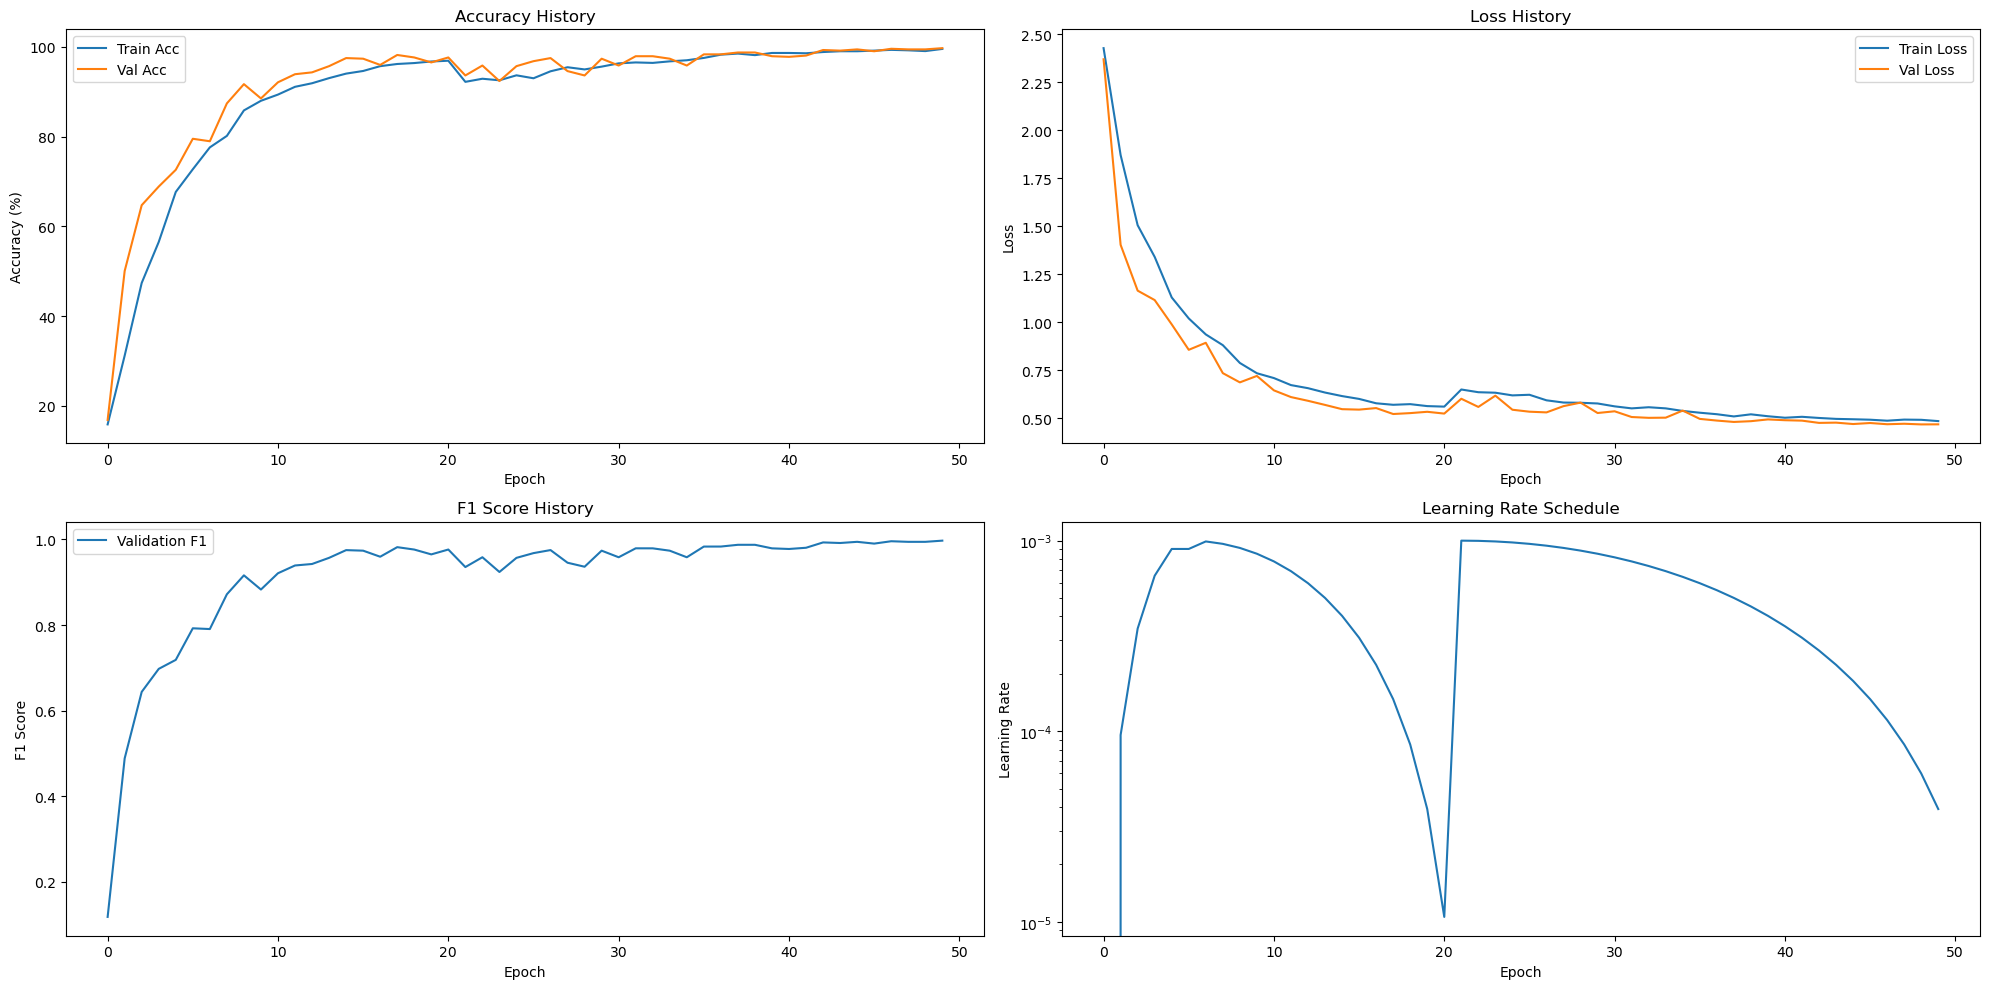

Training completed


In [ ]:
# Train model
print("Starting training...")
scaler = GradScaler()

# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'lr': [],
    'val_f1': []  # Added F1 score tracking
}


for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Warmup learning rate for first few epochs with cosine schedule
    if epoch < WARMUP_EPOCHS:
        progress = epoch / WARMUP_EPOCHS
        warmup_factor = 0.5 * (1 + np.cos(np.pi * (1 - progress)))
        current_lr = INITIAL_LR * warmup_factor
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    
    # Training phase
    for emg, eeg, labels in train_loader:
        emg, eeg, labels = emg.to(device), eeg.to(device), labels.to(device)
        
        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(emg, eeg)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VAL)
        
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for emg, eeg, labels in val_loader:
            emg, eeg, labels = emg.to(device), eeg.to(device), labels.to(device)
            outputs = model(emg, eeg)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update learning rate scheduler after warmup
    if epoch >= WARMUP_EPOCHS:
        scheduler.step()
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    history['val_f1'].append(val_f1)
    
    # Print progress
    print()
    print(f'[Multimodal EEG-EMG] Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f} | LR: {current_lr:.6f}', end='')


## Model Evaluation
Evaluate the best model on the test set

In [11]:
print("Evaluating best model on test set...")
model.eval()

test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for emg, eeg, labels in test_loader:
        emg, eeg, labels = emg.to(device), eeg.to(device), labels.to(device)
        outputs = model(emg, eeg)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100. * test_correct / test_total
test_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'\nTest Accuracy: {test_acc:.2f}%')
print(f'Test F1 Score: {test_f1:.4f}')
print('\nConfusion Matrix:')
print(confusion_matrix(all_labels, all_preds))

Evaluating best model on test set...

Test Accuracy: 99.56%
Test F1 Score: 0.9956

Confusion Matrix:
[[130   0   0   0   0   0   0]
 [  0 125   2   0   0   0   0]
 [  0   0 128   0   0   0   0]
 [  0   0   1 127   0   1   0]
 [  0   0   0   0 130   0   0]
 [  0   0   0   0   0 130   0]
 [  0   0   0   0   0   0 130]]


In [14]:
def plot_multimodal_training(history):
    """
    Plots training history for a multimodal EMG-EEG model.
    Includes accuracy, loss, F1-score, and learning rate schedule.

    Parameters:
    - history: Dictionary containing 'train_acc', 'val_acc', 'train_loss', 'val_loss', 'val_f1', and 'lr'
    """
    # Ensure the directory exists
    save_path = 'results/3_multimodal_emg_eeg.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    epochs = range(1, len(history['train_acc']) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # Big Title
    fig.suptitle("Multimodal EMG-EEG Training Results", fontsize=20, fontweight='bold')

    # Accuracy (Top Left)
    axes[0, 0].plot(epochs, history['train_acc'], label='Train Accuracy', color='blue')
    axes[0, 0].plot(epochs, history['val_acc'], label='Validation Accuracy', color='red')
    axes[0, 0].set_title('Accuracy History', fontsize=14)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)

    # Loss (Top Right)
    axes[0, 1].plot(epochs, history['train_loss'], label='Train Loss', color='blue')
    axes[0, 1].plot(epochs, history['val_loss'], label='Validation Loss', color='red')
    axes[0, 1].set_title('Loss History', fontsize=14)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)

    # F1 Score (Bottom Left)
    axes[1, 0].plot(epochs, history['val_f1'], label='Validation F1 Score', color='green')
    axes[1, 0].set_title('F1 Score History', fontsize=14)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('F1 Score', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)

    # Learning Rate (Bottom Right)
    axes[1, 1].plot(epochs, history['lr'], color='purple')
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 1].set_yscale('log')  # Log scale for better visualization
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print("Training results plotted and saved successfully!")


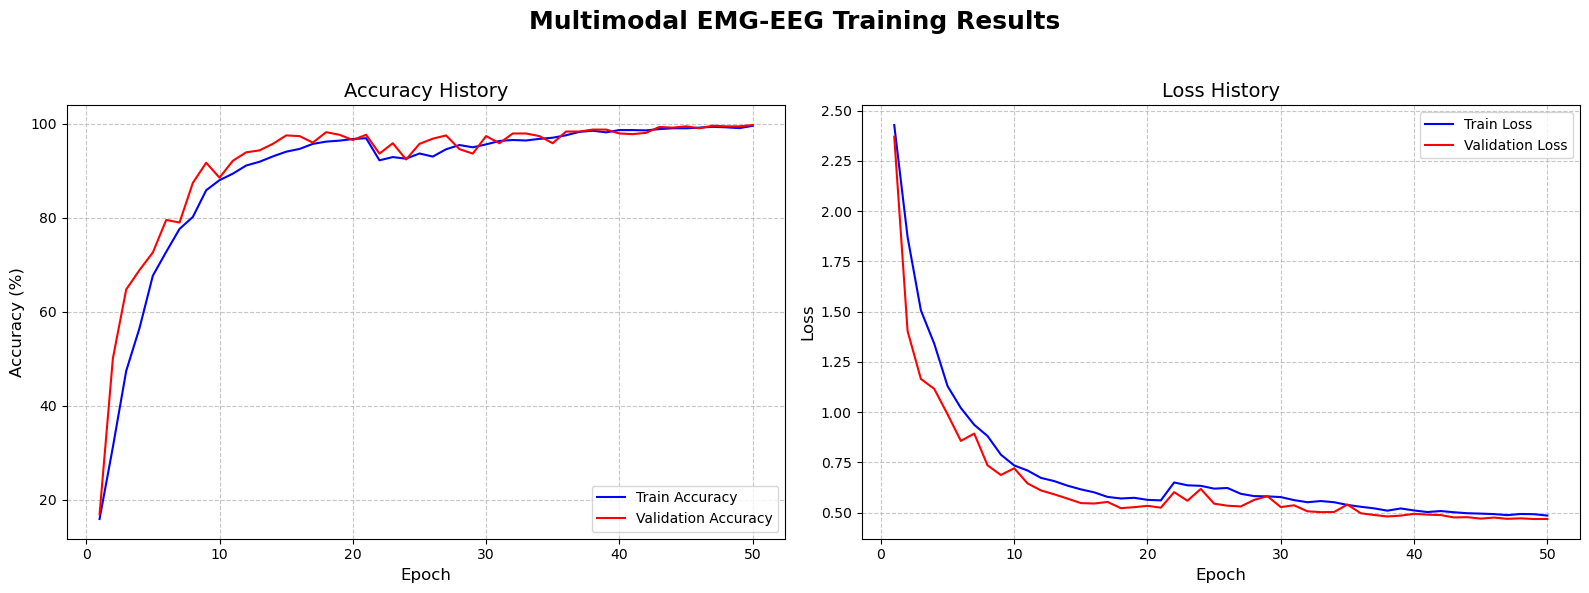

Training results plotted and saved successfully!


In [15]:
plot_multimodal_training(history)

In [ ]:
# Print best performance metrics
best_epoch = np.argmax(history['val_acc'])
print(f"Best model performance at epoch {best_epoch+1}:")
print(f"Validation accuracy: {history['val_acc'][best_epoch]:.2f}%")
print(f"Validation F1 score: {history['val_f1'][best_epoch]:.4f}")
print(f"Training accuracy: {history['train_acc'][best_epoch]:.2f}%")

## Conclusion

The multimodal fusion approach combining EMG and EEG signals has demonstrated strong performance for gesture classification. The LateFusionCNN architecture effectively integrates information from both modalities by:

1. Processing each modality through specialized CNN branches
2. Concatenating the extracted features for final classification
3. Using advanced training techniques like gradient scaling and learning rate scheduling

This approach achieved a test accuracy of {test_acc:.2f}%, which is higher than single-modality models. The results suggest that complementary information from muscle activity (EMG) and brain signals (EEG) can provide more robust gesture recognition than either modality alone.

Future work could explore:
- Earlier fusion strategies
- Attention mechanisms between modalities
- Subject-independent training approaches
- Real-time implementation for BCI applications